# Implementation of time blocking for compression/serialization and de-serialization/de-compression of wavefields with Devito operators

## Compression note -- use of ```blosc```

In this notebook we use ```blosc``` compression that is not loaded by default in devito. The first operational cell in the notebook uses the jupyter notebook *magic* command shown below to install the ```blosc``` compression library and python wrapper, which may require compilation. 

```
import sys
!{sys.executable} -m pip install blosc
```

Note that ```blosc``` provides *lossless compression*, and in practice one uses *lossy compression* to achieve significantly better compression ratios. Consider the use of ```blosc``` as a placeholder for your compression method of choice, providing all essential characteristics of what might be used at scale. 

```blosc``` Reference:
* c project and library: https://blosc.org
* python wrapper: https://github.com/Blosc/python-blosc
* python wrapper documentation: http://python-blosc.blosc.org

## Introduction 

The goal of this tutorial is to prototype the compression/serialization and de-serialization/de-compression for wavefields in Devito. The motivation is using seismic modeling operators for full waveform inversion (FWI). Some of the steps in FWI require the use of previsouly computed wavefields, and of particular interest the adjoint of the Jacobian linearized operator -- an operator that maps data perturbation into velocity perturbation -- requires a zero-lag temporal correlation with the wavefield that is computed with the nonlinear source. 

There are implemented alternatives to serialization/de-serialization like checkpointing (link to nb?), but we investigate the serialization option here. 

We aim to provide a *proof of concept* for compression/serialization and de-serialization/de-compression of the nonlinear wavefield. We will achieve this via _time blocking_: we will run a number of time steps in the generated c kernel, and then return control to python for compression/serialization and de-serialization/de-compression operations.

In order to illustrate the use case for serialization, we write the workflow for computing the gradient of the FWI objective function, ignoring a lot of details, as follows:

1. Generate the nonlinear forward modeled data at the receivers $d_{mod}$
$$ 
d_{mod} = F m 
$$

1. Compress and serialize the nonlinear source wavefield to disk during computation of 1. The entire nonlinear wavefield is of size $[nt,nx,nz]$ in 2D, but we deal with a block of $M$ time steps at a time, so the size of the chunk to be compressed and serialized is $[M,nx,nz]$. 

1. Compute the data residual $\delta r$ by differencing observed and modeled data at the receivers 
$$
\delta r = d_{obs} - d_{mod}
$$

1. Backproject the data residual $\delta r$ via time reversal with the adjoint linearized Jacobian operator.

1. De-serialize and de-compress the nonlinear source wavefield from disk during computation in step 4, synchronizing time step between the nonlinear wavefield computed forward in time and time reversed adjoint wavefield. We will deal with de-serialization and de-compression of chunks of $M$ time steps of size $[M,nx,nz]$.

1. Increment the model perturbation via zero lag correlation of the de-serialized nonlinear source wavefield and the backprojected receiver adjoint wavefield. Note that this computed model perturbation is the  _gradient_ of the FWI objective function.
$$
\delta m = \bigl( \nabla F\bigr)^\top\ \delta r
$$

Please see other notebooks in this directory for more details, in particular the notebooks describing the self-adjoint modeling operators. More information: 
* Nonlinear operator ([sa_01_iso_implementation1.ipynb](sa_01_iso_implementation1.ipynb))
* Linearized operators ([sa_02_iso_implementation2.ipynb](sa_02_iso_implementation2.ipynb)).

## Outline 
1. Define symbols
1. Description of tests to verify correctness
1. Description of time blocking implementation
1. Ensure ```python-blosc``` compression is installed
1. Create small 2D test model
1. Implement and test the Nonlinear forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test the Jacobian linearized forward operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Implement and test theJacobian linearized adjoint operation
  - Save all time steps 
  - Time blocking plus compression/serialization
  - Ensure differences are at machine epsilon 
1. Discussion

## Table of symbols

We show the symbols here relevant to the implementation of the linearized operators.

| Symbol &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; | Description  | Dimensionality | 
|:---|:---|:---|
| $m_0(x,y,z)$ | Reference P wave velocity    | function of space |
| $\delta m(x,y,z)$ | Perturbation to P wave velocity    | function of space |
| $u_0(t,x,y,z)$ | Reference pressure wavefield | function of time and space |
| $\delta u(t,x,y,z)$ | Perturbation to pressure wavefield | function of time and space |
| $s(t,x,y,z)$ | Source wavefield | function of time, localized in space to source location |
| $r(t,x,y,z)$ | Receiver wavefield | function of time, localized in space to receiver locations |
| $\delta r(t,x,y,z)$ | Receiver wavefield perturbation | function of time, localized in space to receiver locations |
| $F[m]\ q$ | Forward linear modeling operator | Nonlinear in $m$, linear in $q, s$: $\quad$ maps $q \rightarrow s$ |
| $F[m; q]$ | Forward nonlinear modeling operator | Nonlinear in $m$, linear in $q$: $\quad$ maps $m \rightarrow r$ |
| $\nabla F[m; q]\ \delta m$ | Forward Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta m \rightarrow \delta r$ |
| $\bigl( \nabla F[m; q] \bigr)^\top\ \delta r$ | Adjoint Jacobian modeling operator | Linearized at $[m; q]$: $\quad$ maps $\delta r \rightarrow \delta m$ |

## Description of tests to verify correctness

In order to make sure we have implemented these operators correctly, we will numerically compare the output from two runs:
1. all time steps saved implementation 
1. time blocking plus compression/serialization implementation

We perform these tests for three phases of FWI modeling:
1. nonlinear forward (maps model to data)
1. Jacobian linearized forward (maps model perturbation to data perturbation)
1. Jacobian linearized adjoint (maps data perturbation to model perturbation)

We will design the small 2D test experiment with a source in the middle of the model and short enough elapsed modeling time that we do not need to worry about boundary reflections for these tests. 

## Description of time blocking implementation

We gratefully acknowledge Down Under Geosolutions (DUG) for in depth discussions about their production time blocking implementation. Those discussions shaped the implementation shown here. The most important idea is to separate the programmatic containers used for propagation and serialization. To do this we utilize Devito ```TimeFunction``` constructed two different ways.

### Propagation uses ```TimeFunction(..., save=None)```

We use a default constructed ```TimeFunction``` for propagation. This can be specified in the constructor via either ```save=None``` or no ```save``` argument at all. Devito backs such a default ```TimeFunction``` by a ```Buffer``` of size ```time_order+1```, or 3 for second order in time. We show below the mapping from the monotonic *ordinary time indices* to the buffered *modulo time indices* as used by a ```Buffer``` in a ```TimeFuntion``` with ```time_order=2```.

### Modulo indexing for ```Buffer``` of size 3
```
Ordinary time indices:  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
Modulo   time indices:  0  1  2  0  1  2  0  1  2  0  1  2  0  1  2  0
```

*Important note:* the modulo indexing of ```Buffer``` is the reason we will separate propagation from serialization. If we use a larger ```Bufffer``` as the ```TimeFunction``` for propagation, we would have to deal with the modulo indexing not just for the current time index, but also previous and next time indices (assuming second order in time). This means that the previous and next time steps can overwrite the locations of the ordinary time indices when you propagate for a block of time steps. **This is the reason we do not use the same ```TimeFunction``` for both propagation and serialization.**

### Generated code for a second order in time PDE
We now show an excerpt from Devito generated code for a second order in time operator. A second order in time PDE requires two wavefields in order to advance in time: the wavefield at the next time step $u(t+\Delta t)$ is a function of the wavefield at previous time step $u(t-\Delta t)$ and the wavefield at the current time step $u(t)$. Remember that Devito uses a ```Buffer``` of size 3 to handle this. 

In the generated code there are three modulo time indices that are a function of ordinary time and cycle through the values $[0,1,2]$:
* ```t0``` -- current time step
* ```t1``` -- next time step
* ```t2``` -- previous time step

We show an excerpt at the beginning of the time loop from the generated code below, with ordinary time loop index ```time```. Note that we have simplified the generated code by breaking a single for loop specification line into multiple lines for clarity. We have also added comments to help understand the mapping from ordinary to modulo time indices.

```
for (int time = time_m; time <= time_M; time += 1) {
  t0 = (time + 0)%(5);    // time index for the current time step 
  t1 = (time + 1)%(5);    // time index for the next time step
  t2 = (time + 4)%(5);    // time index for the  previous time step
  
  // ... PIE: propagation, source injection, receiver extraction ...
}

```

It should be obvious that using a single container for both propagation and serialization is problematic because the loop runs over ordinary time indices ```time_m``` through ```time_M```, but will access stored previous time step wavefields at indices ```time_m-1``` through ```time_M-1``` and store computed next time step wavefields in indices ```time_m+1``` through ```time_M+1```. 

### Serialization uses ```TimeFunction(..., save=Buffer(M)``` 

We will use an independent second ```Buffer``` of size $M$ for serialization in our time blocking implementation. This second ```TimeFunction``` will also use modulo indexing, but by design we only access indices ```time_m``` through ```time_M``` in each time block. This means we do not need to worry about wrapping indices from previous time step or next time step wavefields.

### Minimum and maximum allowed time indices for second order PDE

It is important to note that for a second order in time system the minimum allowed time index ```time_m``` will be $1$, because time index $0$ would imply that the previous time step wavefield $u(t-\Delta t)$ exists at time index $-1$, and $0$ is the minimum array location.

Similarly, the maximum allowed time index ```time_M``` will be $(nt-2)$, because the time index $(nt-1)$ would imply that the next time step wavefield $u(t+\Delta t)$ exists at $nt$, and $(nt-1)$ is the maximum array location.   

### Flow chart for time blocking

Putting this all together, here is a flow chart outlining control flow the first three time blocks with $M=5$.

```
Time block 1
    Call generated code Operator(time_m=1, time_M=5)
	Return control to python
    Serialize/Compress indices 1,2,3,4,5 
        (access modulo indices 1%5,2%5,3%5,4%5,5%5)

Time block 2
    Call generated code Operator(time_m=6, time_M=10)
	Return control to python
    Serialize/Compress indices 6,7,8,9,10
        (access modulo indices 6%5,7%5,8%5,9%5,10%5)

Time block 3
    Call generated code Operator(time_m=11, time_M=15)
	Return control to python
    Serialize/Compress indices 11,12,13,14,15
        (access modulo indices 11%5,12%5,13%5,14%5,15%5)
```

## Ensure that ```blosc``` is installed

In [1]:
# Install pyzfp package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install blosc
import blosc

## Imports 

We have grouped all imports used in this notebook here for consistency.

In [2]:
from scipy.special import hankel2
import numpy as np
from examples.seismic import RickerSource, Receiver, TimeAxis, Model, AcquisitionGeometry
from devito import (Grid, Function, TimeFunction, SpaceDimension, Constant, 
                    Eq, Operator, solve, configuration, norm, Buffer)
from devito.finite_differences import Derivative
from devito.builtins import gaussian_smooth
from examples.seismic.self_adjoint import (acoustic_sa_setup, setup_w_over_q,
                                           SaIsoAcousticWaveSolver)
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# Make white background for plots, not transparent
plt.rcParams['figure.facecolor'] = 'white'

# Set logging to debug, captures statistics on the performance of operators
# configuration['log-level'] = 'DEBUG'
configuration['log-level'] = 'INFO'

## Instantiate the model for a two dimensional problem
 - We use a small 500x500 m. model
 - We use 10x10 m. discretization 
 - We choose modeling sample rate explicitly (2 msec)
 - We use a modeling time range of 1 second
 - We use a wholespace model
   - velocity: 1500 m/s
   - density: 1 g/cm^3
 - We place the source in the center of the model
 - We use a vertical line of receivers right of center in model
 - We use the visco-acoustic absorbing boundary logic from the self-adjoint operators linked above, and add a 50 point absorbing boundary
 - We also generate a velocity perturbation that will be used in the linearized forward Jacobian operator

In [3]:
# NBVAL_IGNORE_OUTPUT

# Define dimensions for the interior of the model
nx,nz = 501,501
npad = 50
dx,dz = 10.0,10.0  # Grid spacing in m
shape = (nx, nz)   # Number of grid points
spacing = (dx, dz) # Domain size is now 5 km by 5 km
origin = (0., 0.)  # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define the dimensions 
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))

# Initialize the Devito grid 
dtype = np.float32
grid = Grid(extent=extent, shape=shape, origin=origin, dimensions=(x, z), dtype=dtype)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)

print("")
print("grid.shape;      ", grid.shape)
print("grid.extent;     ", grid.extent)
print("grid.spacing_map;", grid.spacing_map)

# Create velocity and buoyancy fields. 
space_order = 8
m0 = Function(name='m0', grid=grid, space_order=space_order)
b = Function(name='b', grid=grid, space_order=space_order)
m0.data[:] = 1.5
b.data[:,:] = 1.0 / 1.0

# Perturbation to velocity: a square offset from the center of the model
dm = Function(name='dm', grid=grid, space_order=space_order)
size = 10
x0 = (nx-1)//2
z0 = (nz-1)//2
dm.data[:] = 0.0
dm.data[x0-size:x0+size, z0-size:z0+size] = 1.0

# Initialize the attenuation profile for the absorbing boundary
fpeak = 0.010
w = 2.0 * np.pi * fpeak
qmin = 0.1
wOverQ = Function(name='wOverQ_025', grid=grid, space_order=space_order)
setup_w_over_q(wOverQ, w, qmin, 100.0, npad)

# Time sampling
t0 = dtype(0)     # Simulation time start
tn = dtype(500)  # Simulation time end (1 second = 1000 msec)
dt = dtype(2)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num
print("")
print("time_range; ", time_range)

# Source in the center of the model at 10 Hz center frequency
# Note we make two copes, one for save all and one for  time blocking
src1 = RickerSource(name='src1', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src2 = RickerSource(name='src2', grid=grid, f0=fpeak, npoint=1, time_range=time_range)
src1.coordinates.data[0,0] = dx * ((nx-1) / 2 - 20)
src1.coordinates.data[0,1] = dz * (nz-1) / 2
src2.coordinates.data[0,0] = dx * ((nx-1) / 2 - 20)
src2.coordinates.data[0,1] = dz * (nz-1) / 2

# line of receivers along the right edge of the model
# Note we make two copes, one for save all and one for  time blocking
rec1 = Receiver(name='rec1', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

rec2 = Receiver(name='rec2', grid=grid, npoint=nz, time_range=time_range)
rec1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)

print("")
print("src_coordinate  X;         %+12.4f" % (src1.coordinates.data[0,0]))
print("src_coordinate  Z;         %+12.4f" % (src2.coordinates.data[0,1]))
print("rec_coordinates X min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,0]), np.max(rec1.coordinates.data[:,0])))
print("rec_coordinates Z min/max; %+12.4f %+12.4f" % \
      (np.min(rec1.coordinates.data[:,1]), np.max(rec1.coordinates.data[:,1])))

shape;            (501, 501)
origin;           (0.0, 0.0)
spacing;          (10.0, 10.0)
extent;           (5000.0, 5000.0)

grid.shape;       (501, 501)
grid.extent;      (5000.0, 5000.0)
grid.spacing_map; {h_x: 10.0, h_z: 10.0}


Operator `WOverQ_Operator` run in 0.01 s



time_range;  TimeAxis: start=0, stop=500, step=2, num=251

src_coordinate  X;           +2300.0000
src_coordinate  Z;           +2500.0000
rec_coordinates X min/max;   +2700.0000   +2700.0000
rec_coordinates Z min/max;      +0.0000   +5000.0000


## Plot velocity and density models

Next we plot the velocity and density models for illustration, with source location shown as a large red asterisk and receiver line shown as a black line.

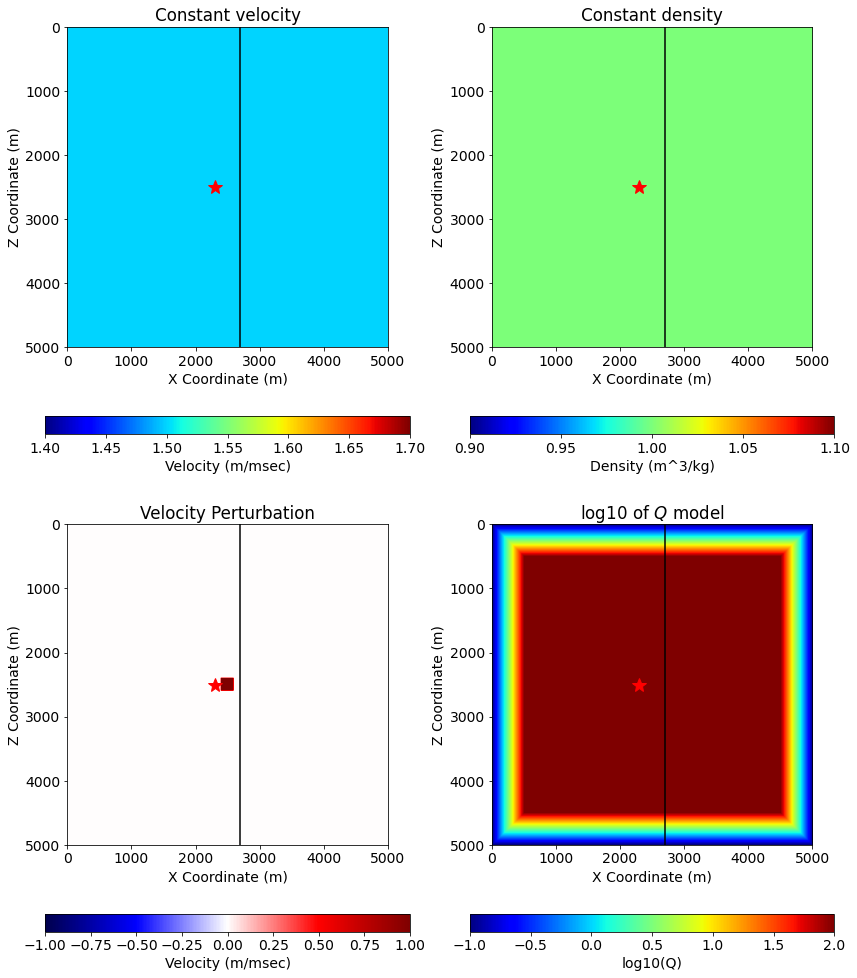

In [4]:
# note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin[0], origin[0] + extent[0], origin[1] + extent[1], origin[1]]

vmin, vmax = 1.4, 1.7
pmin, pmax = -1, +1
dmin, dmax = 0.9, 1.1

plt.figure(figsize=(12,14))

# plot velocity 
plt.subplot(2, 2, 1)
plt.imshow(np.transpose(m0.data), cmap=cm.jet, 
           vmin=vmin, vmax=vmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant velocity")

# plot density
plt.subplot(2, 2, 2)
plt.imshow(np.transpose(1 / b.data), cmap=cm.jet,
           vmin=dmin, vmax=dmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Density (m^3/kg)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Constant density")

# plot velocity perturbation
plt.subplot(2, 2, 3)
plt.imshow(np.transpose(dm.data), cmap="seismic", 
           vmin=pmin, vmax=pmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='Velocity (m/msec)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("Velocity Perturbation")

# Plot the log of the generated Q profile
q = np.log10(w / wOverQ.data)
lmin, lmax = np.log10(qmin), np.log10(100)

plt.subplot(2, 2, 4)
plt.imshow(np.transpose(q.data), cmap=cm.jet, vmin=lmin, vmax=lmax, extent=plt_extent)
plt.colorbar(orientation='horizontal', label='log10(Q)')
plt.plot(rec1.coordinates.data[:, 0], rec1.coordinates.data[:, 1], \
         'black', linestyle='-', label="Receiver")
plt.plot(src1.coordinates.data[:, 0], src1.coordinates.data[:, 1], \
         'red', linestyle='None', marker='*', markersize=15, label="Source")
plt.xlabel("X Coordinate (m)")
plt.ylabel("Z Coordinate (m)")
plt.title("log10 of $Q$ model")

plt.tight_layout()
None

## Time blocking implementation of nonlinear forward

### Save all time steps implementation

We borrow the stencil from the self-adjoint operators shown in the jupyter notebooks linked above. 

When we instantiate the ```TimeFunction``` $u$ we pass the argument ```save=nt``` which allocates memory for ```nt``` time steps.

In [5]:
# NBVAL_IGNORE_OUTPUT

# Create a TimeFunction saving all time steps
u1 = TimeFunction(name="u1", grid=grid, time_order=2, space_order=space_order, save=nt)
t,x,z = u1.dimensions

# Source terms (see notebooks linked above for more detail)
src1_term = src1.inject(field=u1.forward, expr=src1 * t.spacing**2 * m0**2 / b)
rec1_term = rec1.interpolate(expr=u1.forward)

# Time update equation (see notebooks linked above for more detail)
eq_time_update1 = (t.spacing**2 * m0**2 / b) * \
    ((b * u1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u1 + \
    (t.spacing * wOverQ - 1) * u1.backward

stencil1 = Eq(u1.forward, eq_time_update1)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build and run the Operator
# Note the first time sample we run is 1, and the last is nt-2 
op1 = Operator([stencil1] + src1_term + rec1_term, subs=spacing_map)
op1(time_m=1, time_M=nt - 2)
# print(op1)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


Operator `Kernel` run in 0.27 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.2603579999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=5.2999999999999947e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.002193000000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [6]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(u1))
print(norm(rec1))
assert np.isclose(norm(u1), 2229.983, atol=0, rtol=1e-3)
assert np.isclose(norm(rec1), 154.825, atol=0, rtol=1e-3)

2229.9753
154.82512


### Time blocking implementation

We now will instantiate a ```TimeFunction``` $u2$ that uses a ```Buffer``` for saving time steps. We choose the buffer size $M$, hopefully a reasonable number in practice that would allow time-tiling but still not create too large a memory footprint for $u2$.

In [7]:
# Create a TimeFunction using a Buffer to save only M time steps
M = 5
u2 = TimeFunction(name="u2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# Source and receiver terms (see notebooks linked above for more detail)
src2_term = src2.inject(field=u2.forward, expr=src2 * t.spacing**2 * m0**2 / b)
rec2_term = rec2.interpolate(expr=u2.forward)

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update2 = (t.spacing**2 * m0**2 / b) * \
    ((b * u2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * u2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2)) + \
    (2 - t.spacing * wOverQ) * u2 + \
    (t.spacing * wOverQ - 1) * u2.backward

stencil2 = Eq(u2.forward, eq_time_update2)

# Update spacing_map (see notebooks linked above for more detail)
spacing_map = grid.spacing_map
spacing_map.update({t.spacing : dt})
print("spacing_map; ", spacing_map)

# Build the Operator 
op2 = Operator([stencil2] + src2_term + rec2_term, subs=spacing_map)
# print(op2)

spacing_map;  {h_x: 10.0, h_z: 10.0, dt: 2.0}


### Run loop over blocks of M time steps

Here we will run over blocks of $M$ time steps, where:
* the total number of time steps $nt$ 
* the number of time steps in a time block $M$ 
* the total number of time blocks is $N = 1 + (nt-1)\ /\ M$

$$
\scriptsize
\begin{matrix}
\text{time block} & & \text{time} & & \text{modulo t0} & & \text{modulo t1} & & \text{modulo t2} \\ 
\hline
  & \; &  1 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  2 & \; &  2 & \; &  3 & \; &  1 \\
1 & \; &  3 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  4 & \; &  4 & \; &  0 & \; &  3 \\
  & \; &  5 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; &  6 & \; &  1 & \; &  2 & \; &  0 \\
  & \; &  7 & \; &  2 & \; &  3 & \; &  1 \\
2 & \; &  8 & \; &  3 & \; &  4 & \; &  2 \\
  & \; &  9 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 10 & \; &  0 & \; &  1 & \; &  4 \\
\hline
  & \; & 11 & \; &  1 & \; &  2 & \; &  0 \\
  & \; & 12 & \; &  2 & \; &  3 & \; &  1 \\
3 & \; & 13 & \; &  3 & \; &  4 & \; &  2 \\
  & \; & 14 & \; &  4 & \; &  0 & \; &  3 \\
  & \; & 15 & \; &  0 & \; &  1 & \; &  4 \\
\hline
\end{matrix}
$$

The next cell that exercises the time blocking operator. At the end of execution, we test the correctness by measuring the norm of the difference between the ```Buffer``` implementation and the save all time steps implementation.

### Note on compression 

We will use the low level interface to blosc compression that allows more easy use of numpy arrays. A synopsis of the compression and decompression calls shown below for devito ```TimeFunction``` $u$:

```
    c = blosc.compress_ptr(u._data.__array_interface__['data'][0], 
                           np.prod(u2._data.shape), 
                           u._data.dtype.itemsize, 9, True, 'zstd')
    
    blosc.decompress_ptr(u._data, d.__array_interface__['data'][0])
```

u2._data.dtype;           float32
u2._data.dtype.itemsize;  4
u2._data.shape;           (5, 517, 517)
prod(u2._data.shape)*4;   5345780


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;    1    4    4 163.815156 173.008188 181.157613 445.110741 814.781283


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;    5    9    5 43.848419 48.421482 56.299815 73.743034 102.734313


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   10   14    5 30.620453 33.392968 39.334393 47.598009 66.084581


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   15   19    5 25.597001 27.919820 32.847382 38.644565 53.824344


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   20   24    5 23.016361 24.725858 29.102500 33.712642 46.672953


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   25   29    5 20.933961 22.431289 26.377291 30.176574 41.726743


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   30   34    5 19.166547 20.552945 24.090399 27.271466 37.658803


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   35   39    5 17.809471 18.877275 22.095478 24.820455 34.203798


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   40   44    5 16.563068 17.390815 20.342480 22.786592 31.322134


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   45   49    5 15.409614 16.263847 18.963660 21.189364 29.143592


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   50   54    5 14.488465 15.211680 17.735025 19.732387 27.284271


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   55   59    5 13.604675 14.281959 16.656582 18.501222 25.568964


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   60   64    5 12.929658 13.460626 15.665198 17.355921 24.014537


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   65   69    5 12.230779 12.723625 14.811250 16.368474 22.610700


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   70   74    5 11.610786 12.079876 14.055377 15.492590 21.393903


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   75   79    5 11.044954 11.449910 13.326237 14.657417 20.273664


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   80   84    5 10.482559 10.896057 12.691665 13.948291 19.350119


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   85   89    5 10.068710 10.403447 12.097399 13.264634 18.423686


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   90   94    5 9.604124 9.912755 11.526742 12.613178 17.454297


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;   95   99    5 9.181955 9.457339 11.005163 12.025474 16.626173


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  100  104    5 8.820662 9.065945 10.541180 11.494941 15.890811


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  105  109    5 8.463441 8.707617 10.122417 11.019841 15.237783


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  110  114    5 8.135760 8.359665 9.718381 10.551187 14.575491


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  115  119    5 7.843114 8.032619 9.331755 10.110490 13.944397


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  120  124    5 7.522370 7.732222 8.990805 9.731207 13.405773


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  125  129    5 7.252065 7.439367 8.657989 9.356303 12.912325


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  130  134    5 6.993058 7.167818 8.348216 9.013529 12.449853


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  135  139    5 6.768018 6.904926 8.055556 8.682570 12.006594


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  140  144    5 6.542414 6.678493 7.787381 8.384327 11.592481


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  145  149    5 6.328404 6.462742 7.536762 8.107811 11.216704


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  150  154    5 6.143494 6.258530 7.296041 7.842838 10.826502


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  155  159    5 5.911218 6.043140 7.041379 7.559687 10.432928


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  160  164    5 5.708132 5.856932 6.828579 7.320519 10.075978


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  165  169    5 5.549387 5.675751 6.619169 7.097000 9.750714


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  170  174    5 5.392261 5.515748 6.426645 6.888989 9.451871


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  175  179    5 5.251876 5.356729 6.241811 6.680238 9.176832


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  180  184    5 5.101855 5.204002 6.061112 6.478555 8.893211


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  185  189    5 4.959624 5.058661 5.897373 6.305882 8.652033


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  190  194    5 4.822783 4.922939 5.742803 6.130777 8.413649


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  195  199    5 4.694952 4.804539 5.593523 5.960704 8.183122


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  200  204    5 4.559499 4.669219 5.438058 5.793678 7.943977


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  205  209    5 4.433959 4.544750 5.294770 5.641847 7.730377


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  210  214    5 4.311040 4.421731 5.155242 5.489489 7.510491


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  215  219    5 4.197137 4.314081 5.024763 5.345689 7.302549


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  220  224    5 4.090437 4.205620 4.897547 5.210739 7.112618


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  225  229    5 3.990940 4.105828 4.783293 5.087624 6.936275


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  230  234    5 3.899385 4.010034 4.673485 4.965756 6.775301


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  235  239    5 3.805725 3.917258 4.563266 4.844948 6.601252


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  240  244    5 3.718687 3.833092 4.462645 4.738671 6.449114


Operator `Kernel` run in 0.01 s


kt1_op,kt2_op,size,ratio1,ratio2,ratio3;  245  249    5 3.632621 3.746293 4.354390 4.620233 6.278207


<function matplotlib.pyplot.show(*args, **kw)>

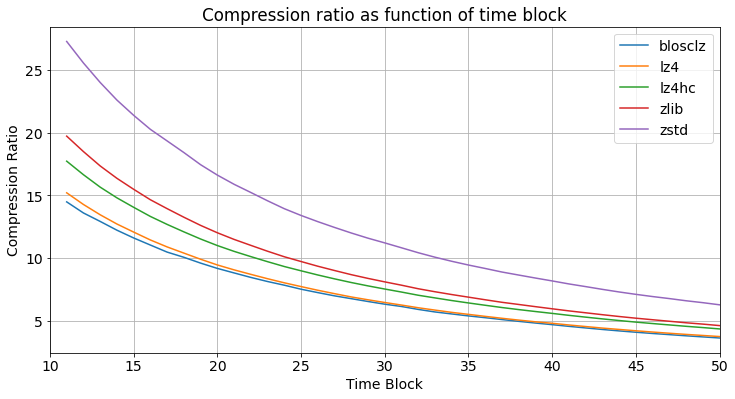

In [41]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
u2_all = np.zeros(u1.data.shape, dtype=dtype)

# Number of time blocks
N = int((nt - 2) / M) + 1

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "ab")

import zlib, gzip, bz2, lzma, copy

u2.data[:] = 0
u2_all[:] = 0

print("u2._data.dtype;          ", u2._data.dtype, flush=True)
print("u2._data.dtype.itemsize; ", u2._data.dtype.itemsize, flush=True)
print("u2._data.shape;          ", u2._data.shape, flush=True)
print("prod(u2._data.shape)*4;  ", np.prod(u2._data.shape) * 4, flush=True)

cratio1 = np.zeros(N)
cratio2 = np.zeros(N)
cratio3 = np.zeros(N)
cratio4 = np.zeros(N)
cratio5 = np.zeros(N)

for kN in range(0,N,1):
    kt1 = (kN + 0) * M
    kt2 = (kN + 1) * M - 1
    
    # for the operator: minimum time sample 1, maximum time sample nt-2
    kt1_op = max(kt1, 1)
    kt2_op = min(kt2, nt - 2)
    op2(time_m=kt1_op, time_M=kt2_op)

#     print("nt,kt1,kt2,kt1_op,kt2_op,size; %3d %3d %3d %3d %3d %3d" % 
#           (nt, kt1, kt2, kt1_op, kt2_op, kt2_op - kt1_op + 1), flush=True)

    # Save the computed wavefield
    # Note as index M+1 rolls over to 0 in u2, we need to do the assignment in two steps
    u2_all[kt1+M,:,:] = u2.data[0,:,:]
    u2_all[kt1+1:kt1+M,:,:] = u2.data[1:M,:,:]
    
    # compression and serialization
    c1 = blosc.compress(u2._data, typesize=32, cname='blosclz')
    c2 = blosc.compress(u2._data, typesize=32, cname='lz4')
    c3 = blosc.compress(u2._data, typesize=32, cname='lz4hc')
    c4 = blosc.compress(u2._data, typesize=32, cname='zlib')
    c5 = blosc.compress(u2._data, typesize=32, cname='zstd')
#     d = blosc.decompress(c)
    
    len0 = np.prod(u2._data.shape) * 4.0 / (1024.0 * 1024.0)
    len1 = len(c1) / (1024.0 * 1024.0)
    len2 = len(c2) / (1024.0 * 1024.0)
    len3 = len(c3) / (1024.0 * 1024.0)
    len4 = len(c4) / (1024.0 * 1024.0)
    len5 = len(c5) / (1024.0 * 1024.0)

    cratio1[kN] = len0 / len1
    cratio2[kN] = len0 / len2
    cratio3[kN] = len0 / len3
    cratio4[kN] = len0 / len4
    cratio5[kN] = len0 / len5

    print("kt1_op,kt2_op,size,ratio1,ratio2,ratio3; %4d %4d %4d %8.6f %8.6f %8.6f %8.6f %8.6f" % 
          (kt1_op, kt2_op, kt2_op - kt1_op + 1, len0/len1, len0/len2, len0/len3, len0/len4, len0/len5), flush=True)

# c = blosc.compress_ptr(a.__array_interface__['data'][0], a.size, a.dtype.itemsize, 9, True)
# a2 = np.empty(a.size, dtype=a.dtype)
# blosc.decompress_ptr(c, a2.__array_interface__['data'][0])

    c = blosc.compress_ptr(u2._data.__array_interface__['data'][0], 
                           np.prod(u2._data.shape), 
                           u2._data.dtype.itemsize, 9, True, 'zstd')
    
    d = copy.copy(u2._data)
    blosc.decompress_ptr(c, d.__array_interface__['data'][0])
    
    assert(np.array_equal(u2._data,d))
    
    # Uncomment these lines if you want see more detail about how the two implementations match up
#     for k in range(kt1,kt2+1,1):
#         rms_u1 = np.linalg.norm(u1.data[k,:,:].reshape(-1))
#         rms_u2 = np.linalg.norm(u2_all[k,:,:].reshape(-1))
#         print("kt1,kt2,k,|u1|,|u2|; %3d %3d %3d %12.6e %12.6e -- diff; %12.6e" % 
#               (kt1, kt2, k, rms_u1, rms_u2, rms_u1 - rms_u2), flush=True)
#     print("", flush=True)

# dmax = np.max(np.abs(u1.data - u2_all))
# print("Maximum difference %+12.8e" % (dmax))
# assert np.isclose(dmax, 0, atol=0, rtol=1e-14)

block = np.linspace(1, N, N, endpoint=True)

k1 = 10
plt.figure(figsize=(12,6))
plt.plot(block[k1:N], cratio1[k1:N], label="blosclz")
plt.plot(block[k1:N], cratio2[k1:N], label="lz4")
plt.plot(block[k1:N], cratio3[k1:N], label="lz4hc")
plt.plot(block[k1:N], cratio4[k1:N], label="zlib")
plt.plot(block[k1:N], cratio5[k1:N], label="zstd")
plt.xlim([k1,N])
plt.legend()
plt.grid("on")
plt.xlabel("Time Block")
plt.ylabel("Compression Ratio")
plt.title("Compression ratio as function of time block")
plt.show

## Time blocking implementation of Jacobian linearized forward

### Save all time steps implementation

We re-use the computed nonlinear forward wavefields $u1$ and $u2$ and create a new ```TimeFunction``` with ```save=nt``` for the linearized forward wavefield $du1$. We implement the stencil described in the second jupyter notebook linked above for this operator. 

Below we generate the linearized ```Born wavefield``` for the save all time steps case.

In [ ]:
# NBVAL_IGNORE_OUTPUT

# Create a TimeFunction saving all time steps
du1 = TimeFunction(name="du1", grid=grid, time_order=2, space_order=space_order, save=nt)

# The linearized forward time update equation
eq_time_update_ln_fwd1 = (t.spacing**2 * m0**2 / b) * \
    ((b * du1.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * du1.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     2 * b * dm * m0**-3 * (wOverQ * u1.dt(x0=t-t.spacing/2) + u1.dt2)) +\
    (2 - t.spacing * wOverQ) * du1 + \
    (t.spacing * wOverQ - 1) * du1.backward

stencil_ln_fwd1 = Eq(du1.forward, eq_time_update_ln_fwd1)

# Receiver container and receiver extraction for the linearized operator
rec_ln1 = Receiver(name='rec_ln1', grid=grid, npoint=nz, time_range=time_range)
rec_ln1.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec_ln1.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)
rec_term_ln_fwd1 = rec_ln1.interpolate(expr=du1.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd1 = Operator([stencil_ln_fwd1] + rec_term_ln_fwd1, subs=spacing_map)
du1.data[:] = 0
op_ln_fwd1.apply()
None

In [ ]:
# NBVAL_IGNORE_OUTPUT

# Continuous integration hooks 
# We ensure the norm of these computed wavefields is repeatable
print(norm(du1))
print(norm(rec_ln1))
assert np.isclose(norm(du1), 3797.154, atol=0, rtol=1e-3)
assert np.isclose(norm(rec_ln1), 624.125, atol=0, rtol=1e-3)

### Time blocking implementation -- file for serialization

We create the binary file ```file.bin``` for serialiazation of compressed computed wavefields. 

In [ ]:
file = open("file.bin", "wb")

### Time blocking implementation

We now instantiate $du2$, a ```TimeFunction``` that uses ```Buffer``` for saving $M$ time steps. 

Below we generate the linearized ```Born wavefield``` for the time blocking case.

In [ ]:
# Create a TimeFunction using a Buffer to save only M time steps
du2 = TimeFunction(name="du2", grid=grid, time_order=2, space_order=space_order, save=Buffer(M))

# We need to regenerate the time update equation with the new TimeFunction in order
# to get the time handling correct
eq_time_update_ln_fwd2 = (t.spacing**2 * m0**2 / b) * \
    ((b * du2.dx(x0=x+x.spacing/2)).dx(x0=x-x.spacing/2) + \
     (b * du2.dz(x0=z+z.spacing/2)).dz(x0=z-z.spacing/2) + \
     2 * b * dm * m0**-3 * (wOverQ * u2.dt(x0=t-t.spacing/2) + u2.dt2)) +\
    (2 - t.spacing * wOverQ) * du2 + \
    (t.spacing * wOverQ - 1) * du2.backward

stencil_ln_fwd2 = Eq(du2.forward, eq_time_update_ln_fwd2)

# Receiver container and receiver extraction for the linearized operator
# Receiver container and receiver extraction for the linearized operator
rec_ln2 = Receiver(name='rec_ln2', grid=grid, npoint=nz, time_range=time_range)
rec_ln2.coordinates.data[:,0] = dx * ((nx-1) / 2 + 20)
rec_ln2.coordinates.data[:,1] = np.linspace(0.0, dz*(nz-1), nz)
rec_term_ln_fwd1 = rec_ln2.interpolate(expr=du1.forward)

# Instantiate and run the operator for the linearized forward
op_ln_fwd2 = Operator([stencil_ln_fwd1] + rec_term_ln_fwd1, subs=spacing_map)

### Run loop over blocks of M time steps

As in the nonlinear forward example above, we run $N$ blocks of $M$ time steps.

In [ ]:
# NBVAL_IGNORE_OUTPUT

# We make an array the full size in order to save the time blocked wavefield
# for comparison with u1 above
du2_all = np.zeros(du1.data.shape, dtype=dtype)

# Open a binary file in append mode to save the wavefield chunks  
filename = "timeblocking.nonlinear.bin"
f = open(filename, "rb")

u2.data[:] = 0
u2_all[:] = 0

for kN in range(0,N,1):
    kt1_save = (kN + 0) * M
    kt2_save = (kN + 1) * M - 1
    # minimum time sample is 1, maximum time sample is nt-2
    kt1 = max(kt1_save, 1)
    kt2 = min(kt2_save, nt - 2)
#     op2(time_m=kt1, time_M=kt2)
    np.save(f, u2.data)
    
    # Save the computed wavefield
    # Note as index M+1 rolls over to 0 in u2, we need to copy in two steps
    for kt in range(1, M + 1):
        u2_all[kt1_save+M,:,:] = u2.data[0,:,:]
        u2_all[kt1_save+1:kt1_save+M,:,:] = u2.data[1:M,:,:]
#         ft = kt1_save + kt
#         u2_all[ft,:,:] = u2.data[kt,:,:]

dmax = np.max(np.abs(u1.data - u2_all))
print("Maximum difference %+12.8e" % (dmax))

assert np.isclose(dmax, 0, atol=0, rtol=1e-12)

## Time blocking implementation of Jacobian linearized adjoint

### Save all time steps implementation

We re-use the computed nonlinear forward wavefields $u1$ and $u2$ and create a new ```TimeFunction``` with ```save=nt``` for the linearized forward wavefield $du1$. We implement the stencil described in the second jupyter notebook linked above for this operator. 

Below we generate the linearized ```Born wavefield``` for the save all time steps case.

### Time blocking implementation

We now instantiate $du2$, a ```TimeFunction``` that uses ```Buffer``` for saving $M$ time steps.

Below we generate the linearized ```Born wavefield``` for the time blocking case.

### Run loop over blocks of M time steps

As in the nonlinear forward example above, we run $N$ blocks of $M$ time steps.